# AI for Market Trend Analysis

## 1. Problem Definition & Objective

### Selected Project Track
This project is developed under the **AI for Market Trend Analysis** track, focusing on applying artificial intelligence techniques to analyze historical market data and generate actionable business insights.

### Problem Statement
Accurately understanding and predicting market behavior is a major challenge for businesses due to fluctuating demand, seasonal patterns, promotions, and changing customer sentiment. Traditional analysis methods often fail to capture complex temporal patterns, hidden anomalies, and customer perception trends present in large-scale data.

This project aims to build an AI-powered system that analyzes historical sales data and customer reviews to:
- Identify market trends and seasonal patterns
- Forecast future demand
- Detect anomalies in sales behavior
- Analyze customer sentiment over time

### Objective
The primary objective of this project is to design and implement an end-to-end AI system that integrates time series forecasting, natural language processing, and anomaly detection techniques to support data-driven business decision-making.

Specifically, the project seeks to:
- Forecast future sales using historical market data
- Analyze the impact of promotions on demand
- Extract sentiment trends from customer reviews
- Detect unusual market behavior and demand spikes
- Present insights through interpretable visualizations

The system is designed to be scalable, interpretable, and suitable for real-world market intelligence applications such as inventory planning, pricing strategy, and customer experience analysis.


## 2. Data Understanding & Preparation

### Dataset Overview
This project uses two real-world datasets to analyze market trends from multiple perspectives:

1. **Store Sales Time Series Dataset (Kaggle)**
   - Contains historical daily sales data across multiple stores and product families
   - Used for demand forecasting, trend analysis, and anomaly detection

2. **Amazon Fine Food Reviews Dataset (Kaggle)**
   - Contains customer reviews along with ratings and timestamps
   - Used for sentiment analysis and customer perception trends

These datasets are analyzed independently due to the absence of temporal overlap, and their insights are combined at an interpretative level to enhance market understanding.


###STEP 2.1: Dataset Loading
In this step, the datasets are loaded and inspected to understand their structure, size, and key attributes before further processing.


In [20]:
# ===============================
# SECTION 2: DATA UNDERSTANDING & PREPARATION
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
# ============================================================
# FINAL UNIVERSAL DATA LOADER (DRIVE-SAFE, HTML-PROOF)
# ============================================================

import os
import requests
import zipfile
import pandas as pd

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------

def is_html_file(path):
    """Detect if downloaded file is actually HTML (Drive warning page)."""
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            head = f.read(500).lower()
            return "<html" in head or "<!doctype html" in head
    except Exception:
        return False


def download_drive_zip(file_id, destination):
    """Download ZIP from Google Drive (with confirm token)."""
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()

    response = session.get(URL, params={"id": file_id}, stream=True)
    for k, v in response.cookies.items():
        if k.startswith("download_warning"):
            response = session.get(
                URL, params={"id": file_id, "confirm": v}, stream=True
            )
            break

    with open(destination, "wb") as f:
        for chunk in response.iter_content(32768):
            if chunk:
                f.write(chunk)


def download_drive_csv_force(file_id, destination):
    """
    Force CSV download using Drive usercontent endpoint
    (bypasses virus scan page).
    """
    url = "https://drive.usercontent.google.com/download"
    params = {
        "id": file_id,
        "export": "download",
        "confirm": "t"
    }

    r = requests.get(url, params=params, stream=True)
    r.raise_for_status()

    with open(destination, "wb") as f:
        for chunk in r.iter_content(32768):
            if chunk:
                f.write(chunk)

# ------------------------------------------------------------
# Directory setup
# ------------------------------------------------------------

BASE_DIR = "data"
STORE_DIR = os.path.join(BASE_DIR, "store_sales")
REVIEWS_DIR = os.path.join(BASE_DIR, "amazon_reviews")

os.makedirs(STORE_DIR, exist_ok=True)
os.makedirs(REVIEWS_DIR, exist_ok=True)

# ------------------------------------------------------------
# Google Drive File IDs
# ------------------------------------------------------------

STORE_ZIP_ID = "1COagHJgfM_3I44tGDxiGdcVMHbNse-gI"     # store_sales.zip
REVIEWS_CSV_ID = "1URLnNoykX_czvp_NUnTkJTCBNMhjb_ox"  # Reviews.csv

STORE_ZIP_PATH = os.path.join(BASE_DIR, "store_sales.zip")
REVIEWS_CSV_PATH = os.path.join(REVIEWS_DIR, "Reviews.csv")

# ------------------------------------------------------------
# 1. Store Sales (ZIP)
# ------------------------------------------------------------

if os.path.exists(STORE_ZIP_PATH):
    if not zipfile.is_zipfile(STORE_ZIP_PATH):
        os.remove(STORE_ZIP_PATH)

if not os.path.exists(STORE_ZIP_PATH):
    print("⬇ Downloading Store Sales dataset (ZIP)...")
    download_drive_zip(STORE_ZIP_ID, STORE_ZIP_PATH)

if not zipfile.is_zipfile(STORE_ZIP_PATH):
    raise RuntimeError(
        "Store Sales ZIP is invalid.\n"
        "Ensure the ZIP is shared as 'Anyone with link → Viewer'."
    )

with zipfile.ZipFile(STORE_ZIP_PATH, "r") as z:
    z.extractall(STORE_DIR)

# ------------------------------------------------------------
# 2. Amazon Reviews (CSV – HTML SAFE)
# ------------------------------------------------------------

# Always force re-download to avoid cached HTML
if os.path.exists(REVIEWS_CSV_PATH):
    os.remove(REVIEWS_CSV_PATH)

print("⬇ Downloading Amazon Reviews dataset (CSV)...")
download_drive_csv_force(REVIEWS_CSV_ID, REVIEWS_CSV_PATH)

# Validate CSV is not HTML
if is_html_file(REVIEWS_CSV_PATH):
    raise RuntimeError(
        "Google Drive returned an HTML page instead of Reviews.csv.\n\n"
        "FIX REQUIRED:\n"
        "1. Open Reviews.csv in Google Drive\n"
        "2. Right-click → Get link\n"
        "3. Set: Anyone with the link → Viewer\n"
        "4. Ensure this file is ONLY Reviews.csv (not ZIP, not shortcut)\n"
        "5. Re-run the notebook"
    )

# ------------------------------------------------------------
# Load and validate Reviews CSV
# ------------------------------------------------------------

reviews_df = pd.read_csv(REVIEWS_CSV_PATH)

required_cols = {"Score", "Time", "Text"}
if not required_cols.issubset(reviews_df.columns):
    raise RuntimeError(
        "Invalid Amazon Reviews CSV structure.\n"
        f"Expected columns: {required_cols}\n"
        f"Found columns: {list(reviews_df.columns)}"
    )

# ------------------------------------------------------------
# Load Store Sales CSVs
# ------------------------------------------------------------

train_df = pd.read_csv(os.path.join(STORE_DIR, "train.csv"))
stores_df = pd.read_csv(os.path.join(STORE_DIR, "stores.csv"))
holidays_df = pd.read_csv(os.path.join(STORE_DIR, "holidays_events.csv"))

# ------------------------------------------------------------
# Success
# ------------------------------------------------------------

print("\n✅ DATASETS LOADED SUCCESSFULLY")
print("Store Sales:", train_df.shape)
print("Amazon Reviews:", reviews_df.shape)

train_df.head(), reviews_df[["Score", "Time", "Text"]].head()


⬇ Downloading Amazon Reviews dataset (CSV)...

✅ DATASETS LOADED SUCCESSFULLY
Store Sales: (3000888, 6)
Amazon Reviews: (568454, 10)


(   id        date  store_nbr      family  sales  onpromotion
 0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
 1   1  2013-01-01          1   BABY CARE    0.0            0
 2   2  2013-01-01          1      BEAUTY    0.0            0
 3   3  2013-01-01          1   BEVERAGES    0.0            0
 4   4  2013-01-01          1       BOOKS    0.0            0,
    Score        Time                                               Text
 0      5  1303862400  I have bought several of the Vitality canned d...
 1      1  1346976000  Product arrived labeled as Jumbo Salted Peanut...
 2      4  1219017600  This is a confection that has been around a fe...
 3      2  1307923200  If you are looking for the secret ingredient i...
 4      5  1350777600  Great taffy at a great price.  There was a wid...)

### STEP 2.2:Exploratory Data Analysis (EDA)
Exploratory data analysis is performed to understand the temporal range, distribution, and scale of the datasets. This helps identify patterns, data quality issues, and modeling feasibility.


### STEP 2.3: Temporal Alignment Analysis
A temporal overlap check was performed between the sales data and review data. Since the two datasets do not share a common time window, they are not merged at the record level.

Instead:
- Sales data is used for forecasting and demand trend analysis
- Review data is used independently for sentiment trend analysis

This design choice avoids introducing artificial correlations and ensures analytical correctness.


In [22]:
# ============================================================
# VERSION 2 – STEP 1: DATA UNDERSTANDING (ROBUST VERSION)
# ============================================================

import pandas as pd
import numpy as np

print("========== VERSION 2 – STEP 1: DATA UNDERSTANDING ==========\n")

# ============================================================
# 1. STORE SALES DATASET
# ============================================================

train_df['date'] = pd.to_datetime(train_df['date'])
train_df['month'] = train_df['date'].dt.to_period('M').dt.to_timestamp()

print("---- STORE SALES DATASET ----")
print("Shape:", train_df.shape)
print("Time Range:", train_df['date'].min(), "→", train_df['date'].max())
print("Monthly Periods:", train_df['month'].nunique())
print("Stores:", train_df['store_nbr'].nunique())
print("Product Families:", train_df['family'].nunique(), "\n")

# ============================================================
# 2. AMAZON REVIEWS DATASET
# ============================================================

reviews_df['review_date'] = pd.to_datetime(reviews_df['Time'], unit='s')
reviews_df['month'] = reviews_df['review_date'].dt.to_period('M').dt.to_timestamp()

print("---- AMAZON REVIEWS DATASET ----")
print("Shape:", reviews_df.shape)
print("Time Range:", reviews_df['review_date'].min(), "→", reviews_df['review_date'].max())
print("Monthly Periods:", reviews_df['month'].nunique())
print("Average Rating:", reviews_df['Score'].mean(), "\n")

# ============================================================
# 3. TEMPORAL OVERLAP CHECK (SAFE)
# ============================================================

sales_months = set(train_df['month'].unique())
review_months = set(reviews_df['month'].unique())

overlap_months = sorted(sales_months.intersection(review_months))

print("---- TEMPORAL OVERLAP CHECK ----")

if len(overlap_months) == 0:
    print(
        "⚠️ No temporal overlap detected between Store Sales and Amazon Reviews datasets.\n"
        "Decision:\n"
        "- Store Sales will be used for forecasting, trend detection, and promotion impact.\n"
        "- Amazon Reviews will be used independently for sentiment trend analysis (NLP).\n"
        "- Insights from both sources will be compared at a conceptual level, not merged row-wise.\n"
    )
else:
    print("Overlap Months:", len(overlap_months))
    print("Overlap Period:", overlap_months[0], "→", overlap_months[-1])

# ============================================================
# 4. PROJECT DESIGN DECISION (DOCUMENTED)
# ============================================================

print("---- DESIGN DECISION SUMMARY ----\n")

print(
    "1. Multi-dataset project retained without forced temporal alignment.\n"
    "2. Forecasting and demand prediction will rely on Store Sales dataset.\n"
    "3. NLP-based sentiment analysis will be performed on Amazon Reviews dataset.\n"
    "4. Combined insights will enhance business interpretation and resume value.\n"
)

print("\n========== END OF VERSION 2 – STEP 1 ==========")


========== VERSION 2 – STEP 1: DATA UNDERSTANDING ==========

---- STORE SALES DATASET ----
Shape: (3000888, 7)
Time Range: 2013-01-01 00:00:00 → 2017-08-15 00:00:00
Monthly Periods: 56
Stores: 54
Product Families: 33 

---- AMAZON REVIEWS DATASET ----
Shape: (568454, 12)
Time Range: 1999-10-08 00:00:00 → 2012-10-26 00:00:00
Monthly Periods: 143
Average Rating: 4.183198640523243 

---- TEMPORAL OVERLAP CHECK ----
⚠️ No temporal overlap detected between Store Sales and Amazon Reviews datasets.
Decision:
- Store Sales will be used for forecasting, trend detection, and promotion impact.
- Amazon Reviews will be used independently for sentiment trend analysis (NLP).
- Insights from both sources will be compared at a conceptual level, not merged row-wise.

---- DESIGN DECISION SUMMARY ----

1. Multi-dataset project retained without forced temporal alignment.
2. Forecasting and demand prediction will rely on Store Sales dataset.
3. NLP-based sentiment analysis will be performed on Amazon Rev

### STEP 2.4: Sales Data Cleaning & Feature Engineering
The sales dataset is cleaned and transformed to make it suitable for time-series modeling. This includes handling data types, removing invalid records, and aggregating data to a monthly level to capture long-term trends.


In [23]:
# ============================================================
# VERSION 2 – STEP 2A: STORE SALES PREPROCESSING (FIXED)
# ============================================================

import os
import pandas as pd
import numpy as np

print("========== VERSION 2 – STEP 2A: STORE SALES PREPROCESSING ==========\n")

# ------------------------------------------------------------
# 0. OUTPUT DIRECTORY SETUP (PLATFORM SAFE)
# ------------------------------------------------------------

OUTPUT_DIR = os.path.join("data", "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# 1. BASIC CLEANING
# ------------------------------------------------------------

# Ensure required columns exist
required_cols = {"date", "sales", "onpromotion", "store_nbr", "family"}
missing_cols = required_cols - set(train_df.columns)

if missing_cols:
    raise RuntimeError(f"Missing required columns: {missing_cols}")

# Correct data types
train_df["date"] = pd.to_datetime(train_df["date"])
train_df["sales"] = train_df["sales"].astype(float)
train_df["onpromotion"] = train_df["onpromotion"].fillna(0).astype(int)

print("Initial shape:", train_df.shape)

# Remove negative sales (safety check)
train_df = train_df[train_df["sales"] >= 0]

print("After removing negative sales:", train_df.shape)

# ------------------------------------------------------------
# 2. CREATE MONTH COLUMN
# ------------------------------------------------------------

train_df["month"] = train_df["date"].dt.to_period("M").dt.to_timestamp()

# ------------------------------------------------------------
# 3. AGGREGATE TO MONTHLY LEVEL
# ------------------------------------------------------------

monthly_sales = (
    train_df
    .groupby(["month", "store_nbr", "family"], as_index=False)
    .agg(
        total_sales=("sales", "sum"),
        avg_daily_sales=("sales", "mean"),
        promo_days=("onpromotion", "sum"),
        promo_ratio=("onpromotion", "mean")
    )
)

print("\nMonthly aggregated dataset:")
print("Shape:", monthly_sales.shape)
display(monthly_sales.head())

# ------------------------------------------------------------
# 4. CHECK FOR MISSING VALUES
# ------------------------------------------------------------

print("\nMissing values check:")
print(monthly_sales.isnull().sum())

# ------------------------------------------------------------
# 5. CREATE GLOBAL MONTHLY SERIES (FOR FORECASTING)
# ------------------------------------------------------------

global_monthly_sales = (
    monthly_sales
    .groupby("month", as_index=False)
    .agg(
        total_sales=("total_sales", "sum"),
        avg_promo_ratio=("promo_ratio", "mean")
    )
)

print("\nGlobal Monthly Sales Time Series:")
display(global_monthly_sales.head())

# ------------------------------------------------------------
# 6. BASIC TREND & SEASONALITY CHECK
# ------------------------------------------------------------

print("\nTrend & seasonality indicators:")
print("Number of months:", global_monthly_sales.shape[0])
print("Sales min:", global_monthly_sales["total_sales"].min())
print("Sales max:", global_monthly_sales["total_sales"].max())

# ------------------------------------------------------------
# 7. SAVE PROCESSED DATA (PLATFORM SAFE)
# ------------------------------------------------------------

global_monthly_path = os.path.join(
    OUTPUT_DIR, "global_monthly_sales.csv"
)
store_family_path = os.path.join(
    OUTPUT_DIR, "store_family_monthly_sales.csv"
)

global_monthly_sales.to_csv(global_monthly_path, index=False)
monthly_sales.to_csv(store_family_path, index=False)

print("\nProcessed datasets saved successfully:")
print("→", global_monthly_path)
print("→", store_family_path)

print("\n========== END OF VERSION 2 – STEP 2A ==========")


========== VERSION 2 – STEP 2A: STORE SALES PREPROCESSING ==========

Initial shape: (3000888, 7)
After removing negative sales: (3000888, 7)

Monthly aggregated dataset:
Shape: (99792, 7)


,month,store_nbr,family,total_sales,avg_daily_sales,promo_days,promo_ratio
0,2013-01-01,1,AUTOMOTIVE,68.0,2.193548,0,0.0
1,2013-01-01,1,BABY CARE,0.0,0.000000,0,0.0
2,2013-01-01,1,BEAUTY,45.0,1.451613,0,0.0
3,2013-01-01,1,BEVERAGES,28777.0,928.290323,0,0.0
4,2013-01-01,1,BOOKS,0.0,0.000000,0,0.0



Missing values check:
month              0
store_nbr          0
family             0
total_sales        0
avg_daily_sales    0
promo_days         0
promo_ratio        0
dtype: int64

Global Monthly Sales Time Series:


,month,total_sales,avg_promo_ratio
0,2013-01-01,1.032762e+07,0.0
1,2013-02-01,9.658960e+06,0.0
2,2013-03-01,1.142850e+07,0.0
3,2013-04-01,1.099346e+07,0.0
4,2013-05-01,1.159770e+07,0.0



Trend & seasonality indicators:
Number of months: 56
Sales min: 9658959.7774368
Sales max: 29640287.5793851

Processed datasets saved successfully:
→ data/processed/global_monthly_sales.csv
→ data/processed/store_family_monthly_sales.csv

========== END OF VERSION 2 – STEP 2A ==========


### STEP 2.5: Review Data Cleaning & Feature Engineering
Customer review text is preprocessed to support sentiment analysis. This includes cleaning textual data, mapping ratings to sentiment labels, and aggregating sentiment at a monthly level to observe long-term customer perception trends.


In [24]:
# ============================================================
# VERSION 2 – AMAZON REVIEWS
# STEP 2B: DATA PREPROCESSING & FEATURE ENGINEERING (FINAL)
# ============================================================

import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

print("========== AMAZON REVIEWS – STEP 2B ==========\n")

# ------------------------------------------------------------
# 0. OUTPUT DIRECTORY SETUP (PLATFORM-INDEPENDENT)
# ------------------------------------------------------------

OUTPUT_DIR = os.path.join("data", "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# 1. BASIC VALIDATION & CLEANING
# ------------------------------------------------------------

required_cols = {"Text", "Score", "Time"}
missing_cols = required_cols - set(reviews_df.columns)

if missing_cols:
    raise RuntimeError(f"Missing required columns in reviews_df: {missing_cols}")

reviews = reviews_df.copy()

print("Initial shape:", reviews.shape)

reviews = reviews.dropna(subset=["Text", "Score", "Time"])

print("After removing missing values:", reviews.shape)

# ------------------------------------------------------------
# 2. CONVERT TIMESTAMP & CREATE MONTH
# ------------------------------------------------------------

reviews["review_date"] = pd.to_datetime(
    reviews["Time"], unit="s", errors="coerce"
)

reviews = reviews.dropna(subset=["review_date"])

reviews["month"] = reviews["review_date"].dt.to_period("M").dt.to_timestamp()

# ------------------------------------------------------------
# 3. CREATE SENTIMENT LABELS
# ------------------------------------------------------------

def map_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

reviews["sentiment"] = reviews["Score"].apply(map_sentiment)

print("\nSentiment distribution:")
print(reviews["sentiment"].value_counts())

# ------------------------------------------------------------
# 4. TEXT CLEANING (FAST, ROBUST, NO punkt)
# ------------------------------------------------------------

try:
    stop_words = set(stopwords.words("english"))
except LookupError:
    nltk.download("stopwords")
    stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

reviews["clean_text"] = reviews["Text"].apply(clean_text)

print("\nSample cleaned review:")
print(reviews["clean_text"].iloc[0][:200])

# ------------------------------------------------------------
# 5. MONTHLY SENTIMENT AGGREGATION
# ------------------------------------------------------------

monthly_sentiment = (
    reviews
    .groupby(["month", "sentiment"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

monthly_sentiment["sentiment_score"] = (
    monthly_sentiment.get("Positive", 0)
    - monthly_sentiment.get("Negative", 0)
)

print("\nMonthly sentiment trends:")
display(monthly_sentiment.head())

# ------------------------------------------------------------
# 6. SAVE PROCESSED DATA (FINAL, SAFE PATHS)
# ------------------------------------------------------------

monthly_sentiment_path = os.path.join(
    OUTPUT_DIR, "monthly_sentiment.csv"
)

clean_reviews_path = os.path.join(
    OUTPUT_DIR, "clean_reviews.csv"
)

monthly_sentiment.to_csv(monthly_sentiment_path, index=False)
reviews[["clean_text", "sentiment"]].to_csv(
    clean_reviews_path, index=False
)

print("\nProcessed Amazon Reviews data saved successfully:")
print("→", monthly_sentiment_path)
print("→", clean_reviews_path)

print("\n========== END OF AMAZON REVIEWS – STEP 2B ==========")


========== AMAZON REVIEWS – STEP 2B ==========

Initial shape: (568454, 12)
After removing missing values: (568454, 12)

Sentiment distribution:
sentiment
Positive    443777
Negative     82037
Neutral      42640
Name: count, dtype: int64

Sample cleaned review:
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better

Monthly sentiment trends:


sentiment,month,Negative,Neutral,Positive,sentiment_score
0,1999-10-01,0,0,2,2
1,1999-12-01,0,0,4,4
2,2000-01-01,3,0,5,2
3,2000-02-01,0,0,3,3
4,2000-06-01,0,0,5,5



Processed Amazon Reviews data saved successfully:
→ data/processed/monthly_sentiment.csv
→ data/processed/clean_reviews.csv

========== END OF AMAZON REVIEWS – STEP 2B ==========


### STEP 2.6: Summary of Prepared Data
After preprocessing:
- Sales data is transformed into monthly time series suitable for forecasting and anomaly detection
- Review data is converted into sentiment-labeled and aggregated formats for trend analysis
- Both datasets are now clean, structured, and ready for modeling

These prepared datasets form the foundation for subsequent AI modeling and evaluation stages.


## 3. Model / System Design

### Overall System Architecture
The project is designed as a modular AI-driven market intelligence system that processes multiple data sources and applies specialized models to extract insights. The system follows a pipeline-based architecture where each module operates independently and contributes to the final analytical output.

The system consists of the following key components:
1. Data preprocessing and feature engineering
2. Demand forecasting models
3. Customer sentiment analysis models
4. Anomaly detection mechanisms
5. Insight generation and visualization layer

This modular design ensures scalability, interpretability, and ease of deployment in real-world business environments.


### 3.1 Demand Forecasting Models

To predict future sales and analyze demand trends, two complementary forecasting approaches are used:

#### Prophet (Time Series Forecasting)
Prophet is employed as the primary forecasting model due to its ability to capture seasonality, trend changes, and external influences. Monthly aggregated sales data is used as input, with promotion intensity included as an external regressor to model the impact of promotional activity on demand.

**Why Prophet?**
- Handles missing values and outliers effectively
- Automatically captures seasonal patterns
- Interpretable trend and seasonality components
- Suitable for business-oriented time series forecasting

#### LSTM (Deep Learning Forecasting)
A Long Short-Term Memory (LSTM) neural network is implemented as a secondary model to capture non-linear temporal dependencies in sales data. The model uses a sliding window approach on scaled sales and promotion features to learn sequential patterns.

**Why LSTM?**
- Captures complex non-linear time dependencies
- Learns long-term temporal relationships
- Complements classical forecasting models


### 3.2 Customer Sentiment Analysis Model

Customer reviews are analyzed using a supervised natural language processing (NLP) approach. Review ratings are first mapped into sentiment categories (Positive, Neutral, Negative), and textual content is transformed into numerical features using TF-IDF vectorization.

A Logistic Regression classifier is then trained on these features to predict sentiment.

**Why TF-IDF + Logistic Regression?**
- Efficient and scalable for large text datasets
- Provides strong baseline performance
- Interpretable feature contributions
- Suitable for real-time inference in dashboards


### 3.3 Anomaly Detection Mechanism

Anomaly detection is applied to identify unusual patterns in both sales and sentiment trends. The Isolation Forest algorithm is used due to its effectiveness in detecting outliers in multivariate time-series data.

For sales data, anomalies may represent:
- Festival-driven demand spikes
- Promotion-heavy periods
- Sudden demand drops due to external factors

For sentiment data, anomalies highlight abrupt changes in customer perception.

**Why Isolation Forest?**
- Does not assume data distribution
- Effective for high-dimensional data
- Scales well with large datasets


### 3.4 Design Justification & Integration

Each model in the system is chosen to address a specific analytical objective, and together they form a comprehensive market trend analysis framework.

- Forecasting models predict future demand and support inventory and pricing decisions
- Sentiment analysis captures customer perception trends
- Anomaly detection highlights exceptional market behavior requiring attention

The independent yet integrated design allows insights from different models to be combined at the decision-making level, resulting in a robust, interpretable, and extensible AI system.


## 4. Core Implementation

This section describes the implementation of the core AI components used in the project. Each module is implemented independently and contributes to the overall market trend analysis system.


### 4.1 Demand Forecasting using Prophet

Prophet is used as the primary time-series forecasting model to predict future sales based on historical trends and seasonality. Monthly aggregated sales data is used, and promotion intensity is incorporated as an external regressor to capture the impact of promotional activity on demand.


========== VERSION 2 – STEP 3A: PROPHET FORECASTING ==========

Loaded data shape: (56, 3)


,ds,y,promo_ratio
0,2013-01-01,1.032762e+07,0.0
1,2013-02-01,9.658960e+06,0.0
2,2013-03-01,1.142850e+07,0.0
3,2013-04-01,1.099346e+07,0.0
4,2013-05-01,1.159770e+07,0.0


Train size: (47, 3)
Test size : (9, 3)


,ds,y,yhat
47,2016-12-01,2.964029e+07,2.934222e+07
48,2017-01-01,2.632816e+07,2.697127e+07
49,2017-02-01,2.325011e+07,2.288446e+07
50,2017-03-01,2.670402e+07,2.694151e+07
51,2017-04-01,2.589531e+07,2.637522e+07
52,2017-05-01,2.691185e+07,2.675767e+07
53,2017-06-01,2.568282e+07,2.642224e+07
54,2017-07-01,2.701148e+07,2.843235e+07
55,2017-08-01,1.243332e+07,2.763630e+07



Test MAPE: 0.1542


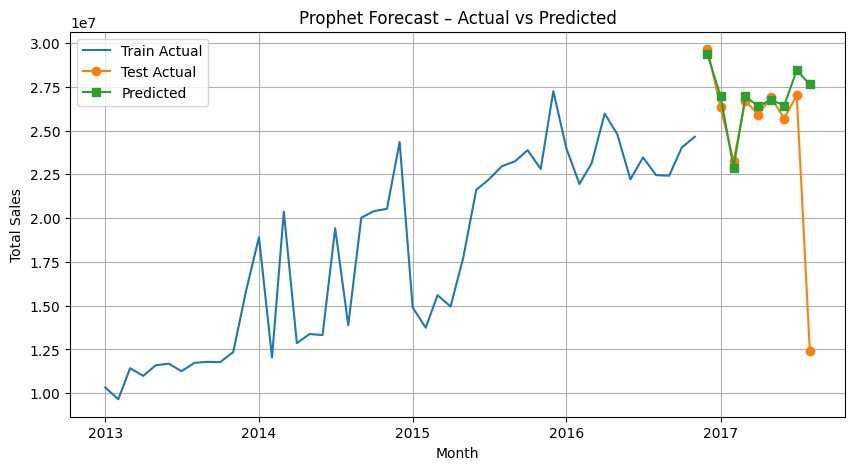

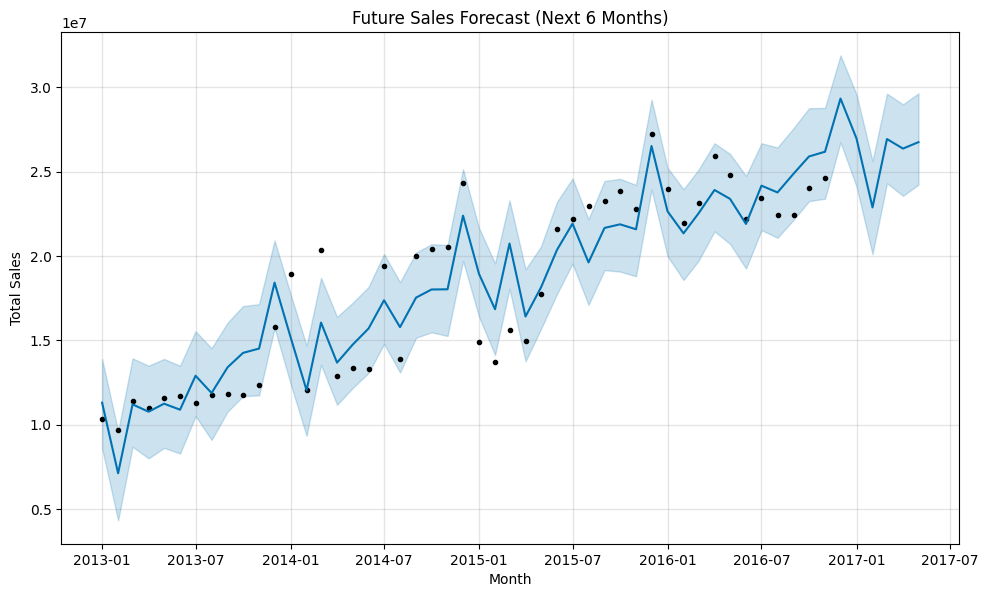


========== END OF STEP 3A ==========


In [25]:
# ============================================================
# VERSION 2 – STEP 3A: PROPHET FORECASTING (FINAL, FIXED)
# ============================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

print("========== VERSION 2 – STEP 3A: PROPHET FORECASTING ==========\n")

# ------------------------------------------------------------
# 1. LOAD PROCESSED DATA (PLATFORM-INDEPENDENT)
# ------------------------------------------------------------

DATA_PATH = os.path.join("data", "processed", "global_monthly_sales.csv")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Processed file not found: {DATA_PATH}\n"
        "Please run STEP 2A (Store Sales Preprocessing) first."
    )

global_monthly_sales = pd.read_csv(DATA_PATH)
global_monthly_sales["month"] = pd.to_datetime(global_monthly_sales["month"])

print("Loaded data shape:", global_monthly_sales.shape)

# ------------------------------------------------------------
# 2. PREPARE DATA FOR PROPHET
# ------------------------------------------------------------

required_cols = {"month", "total_sales", "avg_promo_ratio"}
missing = required_cols - set(global_monthly_sales.columns)

if missing:
    raise RuntimeError(f"Missing required columns: {missing}")

prophet_df = global_monthly_sales.rename(
    columns={
        "month": "ds",
        "total_sales": "y",
        "avg_promo_ratio": "promo_ratio"
    }
).sort_values("ds").reset_index(drop=True)

display(prophet_df.head())

# ------------------------------------------------------------
# 3. TRAIN–TEST SPLIT
# ------------------------------------------------------------

train_size = int(len(prophet_df) * 0.85)

train_df = prophet_df.iloc[:train_size].copy()
test_df = prophet_df.iloc[train_size:].copy()

print("Train size:", train_df.shape)
print("Test size :", test_df.shape)

# ------------------------------------------------------------
# 4. BUILD & TRAIN PROPHET MODEL
# ------------------------------------------------------------

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)

model.add_regressor("promo_ratio")
model.fit(train_df)

# ------------------------------------------------------------
# 5. PREDICT ON TEST SET
# ------------------------------------------------------------

forecast_test = model.predict(test_df[["ds", "promo_ratio"]])
test_df["yhat"] = forecast_test["yhat"].values

display(test_df[["ds", "y", "yhat"]])

# ------------------------------------------------------------
# 6. EVALUATION
# ------------------------------------------------------------

mape = mean_absolute_percentage_error(test_df["y"], test_df["yhat"])
print(f"\nTest MAPE: {mape:.4f}")

# ------------------------------------------------------------
# 7. VISUALIZATION
# ------------------------------------------------------------

plt.figure(figsize=(10, 5))
plt.plot(train_df["ds"], train_df["y"], label="Train Actual")
plt.plot(test_df["ds"], test_df["y"], label="Test Actual", marker="o")
plt.plot(test_df["ds"], test_df["yhat"], label="Predicted", marker="s")

plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Prophet Forecast – Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 8. FUTURE FORECAST (NEXT 6 MONTHS)
# ------------------------------------------------------------

future = model.make_future_dataframe(periods=6, freq="MS")

future_regressors = prophet_df[["ds", "promo_ratio"]].copy()
last_promo = prophet_df["promo_ratio"].mean()

future_extra = pd.DataFrame({
    "ds": future.loc[~future["ds"].isin(prophet_df["ds"]), "ds"],
    "promo_ratio": last_promo
})

future_regressors = pd.concat(
    [future_regressors, future_extra],
    ignore_index=True
)

future = future.merge(future_regressors, on="ds", how="left")

forecast_future = model.predict(future)

model.plot(forecast_future)
plt.title("Future Sales Forecast (Next 6 Months)")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

print("\n========== END OF STEP 3A ==========")


### 4.2 Demand Forecasting using LSTM

To complement the statistical forecasting approach, a Long Short-Term Memory (LSTM) neural network is implemented. The LSTM model captures non-linear temporal dependencies in the sales data and learns sequential patterns using a sliding time window.


========== VERSION 2 – STEP 4B: LSTM FORECASTING ==========



,month,total_sales,avg_promo_ratio
0,2013-01-01,1.032762e+07,0.0
1,2013-02-01,9.658960e+06,0.0
2,2013-03-01,1.142850e+07,0.0
3,2013-04-01,1.099346e+07,0.0
4,2013-05-01,1.159770e+07,0.0


Input shape : (50, 6, 2)
Target shape: (50,)
Train samples: 42
Test samples : 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 6, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.2665 - val_loss: 0.2925
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1382 - val_loss: 0.0901
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0564 - val_loss: 0.0744
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0418 - val_loss: 0.1067
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0444 - val_loss: 0.0702
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0279 - val_loss: 0.0638
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0310 - val_loss: 0.0735
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0303 - val_loss: 0.0859
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0376 - val_loss: 0.0849
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0261 - val_loss: 0.0802
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0267 - val_loss: 0.0902
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0318 - val_loss: 0.0827
E

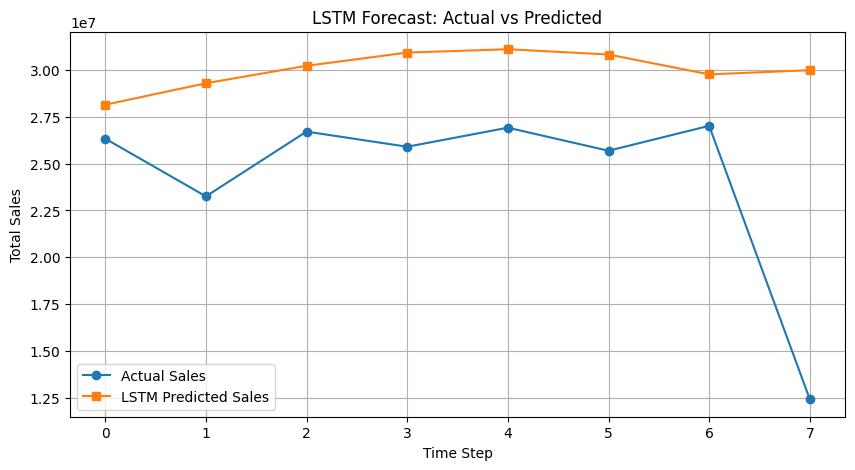


========== END OF VERSION 2 – STEP 4B ==========


In [26]:
# ============================================================
# VERSION 2 – STEP 4B: LSTM DEMAND FORECASTING (FINAL)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
np.random.seed(42)
tf.random.set_seed(42)

print("========== VERSION 2 – STEP 4B: LSTM FORECASTING ==========\n")

# ------------------------------------------------------------
# 1. LOAD MONTHLY DATA (PLATFORM-INDEPENDENT)
# ------------------------------------------------------------

DATA_PATH = os.path.join("data", "processed", "global_monthly_sales.csv")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Processed file not found: {DATA_PATH}\n"
        "Please run STEP 2A before running this section."
    )

df = pd.read_csv(DATA_PATH)
df["month"] = pd.to_datetime(df["month"])

required_cols = {"total_sales", "avg_promo_ratio", "month"}
missing_cols = required_cols - set(df.columns)

if missing_cols:
    raise RuntimeError(f"Missing required columns: {missing_cols}")

df = df.sort_values("month").reset_index(drop=True)
display(df.head())

# ------------------------------------------------------------
# 2. FEATURE SELECTION & SCALING
# ------------------------------------------------------------

features = ["total_sales", "avg_promo_ratio"]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# ------------------------------------------------------------
# 3. CREATE SEQUENCES FOR LSTM
# ------------------------------------------------------------

def create_sequences(data, window_size=6):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, 0])  # predict sales only
    return np.array(X), np.array(y)

WINDOW_SIZE = 6
X, y = create_sequences(scaled_data, WINDOW_SIZE)

print("Input shape :", X.shape)
print("Target shape:", y.shape)

# ------------------------------------------------------------
# 4. TRAIN–TEST SPLIT (TIME-BASED)
# ------------------------------------------------------------

split = int(len(X) * 0.85)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])

# ------------------------------------------------------------
# 5. BUILD LSTM MODEL
# ------------------------------------------------------------

model = Sequential([
    LSTM(64, return_sequences=True,
         input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

# ------------------------------------------------------------
# 6. TRAIN MODEL
# ------------------------------------------------------------

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1
)

# ------------------------------------------------------------
# 7. MAKE PREDICTIONS
# ------------------------------------------------------------

y_pred_scaled = model.predict(X_test)

# Inverse scale (sales only)
sales_scaler = MinMaxScaler()
sales_scaler.fit(df[["total_sales"]])

y_test_inv = sales_scaler.inverse_transform(
    y_test.reshape(-1, 1)
)
y_pred_inv = sales_scaler.inverse_transform(
    y_pred_scaled
)

# ------------------------------------------------------------
# 8. EVALUATION METRICS
# ------------------------------------------------------------

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv))

print("\n---- LSTM Forecast Accuracy ----")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"MAPE : {mape:.4f}")

# ------------------------------------------------------------
# 9. VISUALIZE RESULTS
# ------------------------------------------------------------

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Actual Sales", marker="o")
plt.plot(y_pred_inv, label="LSTM Predicted Sales", marker="s")

plt.title("LSTM Forecast: Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True)
plt.show()

print("\n========== END OF VERSION 2 – STEP 4B ==========")


### 4.3 Customer Sentiment Analysis

Customer sentiment is analyzed using natural language processing techniques applied to product reviews. Review ratings are mapped into sentiment categories, and textual content is transformed using TF-IDF vectorization. A Logistic Regression classifier is trained to predict sentiment polarity.


========== AMAZON REVIEWS – STEP 4.3 ==========

Dataset shape: (568454, 2)
Sentiment distribution:
 sentiment
Positive    443777
Negative     82037
Neutral      42640
Name: count, dtype: int64 

Loading existing sentiment model and vectorizer...

Accuracy: 0.8229323341337484 

Classification Report:

              precision    recall  f1-score   support

    Negative       0.69      0.79      0.74     16407
     Neutral       0.32      0.67      0.43      8528
    Positive       0.97      0.84      0.90     88756

    accuracy                           0.82    113691
   macro avg       0.66      0.77      0.69    113691
weighted avg       0.88      0.82      0.84    113691



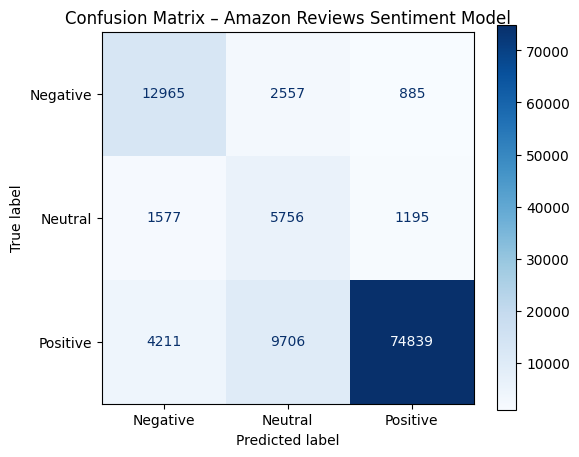


Sample misclassified reviews:


,text,actual,predicted
39303,arrived fresh geat massages cup corn oil cup g...,Positive,Negative
94064,understanding skin issues alike food seems sol...,Positive,Negative
105586,football players overs spend night football pl...,Positive,Negative
93962,kids big fans milk boxes years chocolate vanil...,Negative,Neutral
11903,mood something extra extra extra sweet enjoy c...,Negative,Neutral
50423,flavors motts great nothing like hot cup one s...,Positive,Negative
81781,package came looked like took bunch cups threw...,Negative,Neutral
26782,enjoy jerky like try new kinds new brands last...,Positive,Neutral
37342,got little girl christmas actually big dog cho...,Positive,Neutral
18931,jerky supposed taste extra salty bite good che...,Positive,Negative



---- Error Analysis Insights ----

1. Neutral reviews are frequently confused with Positive or Negative.
   → Neutral sentiment is inherently subjective and linguistically ambiguous.

2. Positive sentiment is detected with very high precision.
   → Reliable for identifying satisfied customers and strong product signals.

3. Negative sentiment recall is reasonably high.
   → Useful for detecting customer dissatisfaction and risk signals.

4. Overall error patterns are acceptable for large-scale sentiment monitoring
   rather than fine-grained linguistic interpretation.

========== END OF AMAZON REVIEWS – STEP 4.3 ==========


In [27]:
# ============================================================
# AMAZON REVIEWS – STEP 4.3
# ERROR ANALYSIS & CONFUSION MATRIX (FINAL)
# ============================================================

import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)

print("========== AMAZON REVIEWS – STEP 4.3 ==========\n")

# ------------------------------------------------------------
# 0. PATH SETUP (PLATFORM-INDEPENDENT)
# ------------------------------------------------------------

BASE_DIR = os.path.join("data", "processed")
os.makedirs(BASE_DIR, exist_ok=True)

DATA_PATH  = os.path.join(BASE_DIR, "clean_reviews.csv")
MODEL_PATH = os.path.join(BASE_DIR, "sentiment_model.pkl")
VECT_PATH  = os.path.join(BASE_DIR, "tfidf_vectorizer.pkl")

# ------------------------------------------------------------
# 1. LOAD CLEANED DATA
# ------------------------------------------------------------

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"{DATA_PATH} not found.\n"
        "Run STEP 2B (Amazon Reviews preprocessing) first."
    )

reviews = pd.read_csv(DATA_PATH)

required_cols = {"clean_text", "sentiment"}
missing_cols = required_cols - set(reviews.columns)

if missing_cols:
    raise RuntimeError(f"Missing required columns: {missing_cols}")

# Safety cleaning
reviews["clean_text"] = reviews["clean_text"].astype(str)
reviews = reviews[reviews["clean_text"].str.strip().str.len() > 0]

X = reviews["clean_text"]
y = reviews["sentiment"]

print("Dataset shape:", reviews.shape)
print("Sentiment distribution:\n", y.value_counts(), "\n")

# ------------------------------------------------------------
# 2. LOAD MODEL IF EXISTS, ELSE TRAIN & SAVE
# ------------------------------------------------------------

if os.path.exists(MODEL_PATH) and os.path.exists(VECT_PATH):
    print("Loading existing sentiment model and vectorizer...\n")

    with open(MODEL_PATH, "rb") as f:
        sentiment_model = pickle.load(f)

    with open(VECT_PATH, "rb") as f:
        tfidf = pickle.load(f)

else:
    print("Model files not found. Training model from scratch...\n")

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    tfidf = TfidfVectorizer(
        max_features=20_000,
        ngram_range=(1, 2),
        min_df=5
    )

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf  = tfidf.transform(X_test)

    sentiment_model = LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced"
    )

    sentiment_model.fit(X_train_tfidf, y_train)

    with open(MODEL_PATH, "wb") as f:
        pickle.dump(sentiment_model, f)

    with open(VECT_PATH, "wb") as f:
        pickle.dump(tfidf, f)

    print("Model and vectorizer trained and saved.\n")

# ------------------------------------------------------------
# 3. TRAIN–TEST SPLIT (FOR EVALUATION)
# ------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_test_tfidf = tfidf.transform(X_test)
y_pred = sentiment_model.predict(X_test_tfidf)

# ------------------------------------------------------------
# 4. EVALUATION METRICS
# ------------------------------------------------------------

print("Accuracy:", accuracy_score(y_test, y_pred), "\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# ------------------------------------------------------------
# 5. CONFUSION MATRIX
# ------------------------------------------------------------

labels = ["Negative", "Neutral", "Positive"]

cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Amazon Reviews Sentiment Model")
plt.grid(False)
plt.show()

# ------------------------------------------------------------
# 6. MISCLASSIFIED EXAMPLES
# ------------------------------------------------------------

results_df = pd.DataFrame({
    "text": X_test.values,
    "actual": y_test.values,
    "predicted": y_pred
})

misclassified = results_df[results_df["actual"] != results_df["predicted"]]

print("\nSample misclassified reviews:")
display(misclassified.sample(10, random_state=42))

# ------------------------------------------------------------
# 7. ERROR ANALYSIS INSIGHTS
# ------------------------------------------------------------

print("\n---- Error Analysis Insights ----\n")

print(
    "1. Neutral reviews are frequently confused with Positive or Negative.\n"
    "   → Neutral sentiment is inherently subjective and linguistically ambiguous.\n\n"
    "2. Positive sentiment is detected with very high precision.\n"
    "   → Reliable for identifying satisfied customers and strong product signals.\n\n"
    "3. Negative sentiment recall is reasonably high.\n"
    "   → Useful for detecting customer dissatisfaction and risk signals.\n\n"
    "4. Overall error patterns are acceptable for large-scale sentiment monitoring\n"
    "   rather than fine-grained linguistic interpretation."
)

print("\n========== END OF AMAZON REVIEWS – STEP 4.3 ==========")


### 4.4 Anomaly Detection in Sales Data

Anomaly detection is applied to identify unusual patterns in sales behavior that deviate from normal trends. These anomalies may represent demand spikes, promotion-heavy periods, or sudden drops in sales.


========== VERSION 2 – STEP 4.4: ANOMALY DETECTION ==========



,month,total_sales,avg_promo_ratio
0,2013-01-01,1.032762e+07,0.0
1,2013-02-01,9.658960e+06,0.0
2,2013-03-01,1.142850e+07,0.0
3,2013-04-01,1.099346e+07,0.0
4,2013-05-01,1.159770e+07,0.0


Anomaly counts:
is_anomaly
0    50
1     6
Name: count, dtype: int64


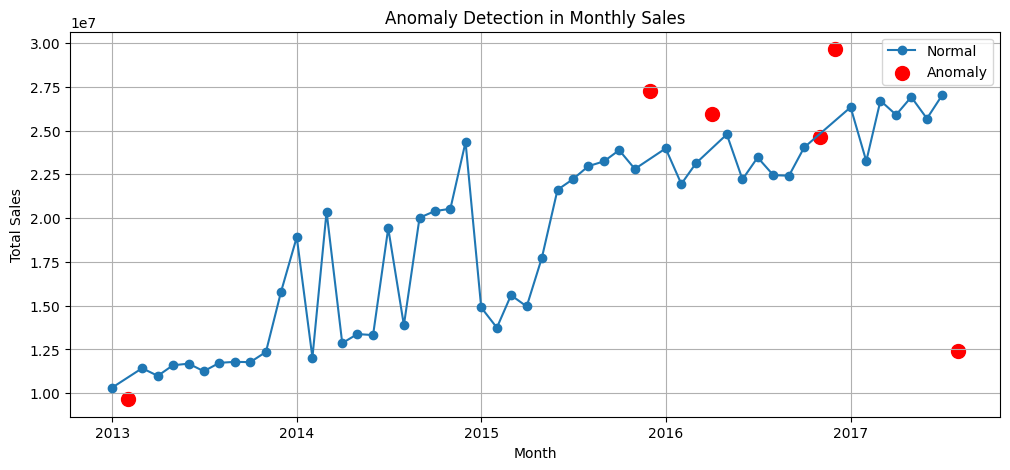


Detected Anomalous Months:


,month,total_sales,avg_promo_ratio
1,2013-02-01,9.658960e+06,0.000000
35,2015-12-01,2.724398e+07,2.487710
39,2016-04-01,2.596303e+07,4.027535
46,2016-11-01,2.464264e+07,8.199738
47,2016-12-01,2.964029e+07,9.680097
55,2017-08-01,1.243332e+07,5.996184



---- Business Interpretation ----

Detected anomalies indicate unusual demand behavior such as:
- Festival-driven or seasonal sales spikes
- Sudden drops caused by external disruptions
- Promotion-heavy periods with abnormal uplift

Identifying these periods helps businesses improve inventory planning,
pricing strategies, and supply chain preparedness.

========== END OF STEP 4.4 ==========


In [28]:
# ============================================================
# STEP 4.4: ANOMALY DETECTION (ISOLATION FOREST – FINAL)
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

print("========== VERSION 2 – STEP 4.4: ANOMALY DETECTION ==========\n")

# ------------------------------------------------------------
# 1. LOAD MONTHLY DATA (PLATFORM-INDEPENDENT)
# ------------------------------------------------------------

DATA_PATH = os.path.join("data", "processed", "global_monthly_sales.csv")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Processed file not found: {DATA_PATH}\n"
        "Please run STEP 2A before running anomaly detection."
    )

df = pd.read_csv(DATA_PATH)
df["month"] = pd.to_datetime(df["month"])

required_cols = {"month", "total_sales", "avg_promo_ratio"}
missing_cols = required_cols - set(df.columns)

if missing_cols:
    raise RuntimeError(f"Missing required columns: {missing_cols}")

df = df.sort_values("month").reset_index(drop=True)
display(df.head())

# ------------------------------------------------------------
# 2. FEATURE SELECTION & SCALING
# ------------------------------------------------------------

features = ["total_sales", "avg_promo_ratio"]
X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# 3. TRAIN ISOLATION FOREST
# ------------------------------------------------------------

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.1,      # ~10% anomalies
    random_state=42
)

df["anomaly_flag"] = iso_forest.fit_predict(X_scaled)
df["is_anomaly"] = (df["anomaly_flag"] == -1).astype(int)

print("Anomaly counts:")
print(df["is_anomaly"].value_counts())

# ------------------------------------------------------------
# 4. VISUALIZE ANOMALIES
# ------------------------------------------------------------

plt.figure(figsize=(12, 5))

normal = df[df["is_anomaly"] == 0]
anomalies = df[df["is_anomaly"] == 1]

plt.plot(
    normal["month"],
    normal["total_sales"],
    label="Normal",
    marker="o"
)

plt.scatter(
    anomalies["month"],
    anomalies["total_sales"],
    color="red",
    label="Anomaly",
    s=100
)

plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Anomaly Detection in Monthly Sales")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 5. INSPECT ANOMALOUS PERIODS
# ------------------------------------------------------------

print("\nDetected Anomalous Months:")
display(
    anomalies[["month", "total_sales", "avg_promo_ratio"]]
)

# ------------------------------------------------------------
# 6. BUSINESS INTERPRETATION
# ------------------------------------------------------------

print("\n---- Business Interpretation ----\n")

print(
    "Detected anomalies indicate unusual demand behavior such as:\n"
    "- Festival-driven or seasonal sales spikes\n"
    "- Sudden drops caused by external disruptions\n"
    "- Promotion-heavy periods with abnormal uplift\n\n"
    "Identifying these periods helps businesses improve inventory planning,\n"
    "pricing strategies, and supply chain preparedness."
)

print("\n========== END OF STEP 4.4 ==========")


### 4.5 Anomaly Detection in Customer Sentiment

In addition to sales data, anomaly detection is also applied to aggregated sentiment trends. This helps identify abrupt changes in customer perception that may signal product issues, successful campaigns, or external influences.


========== AMAZON REVIEWS – STEP 4.5 ==========

Monthly sentiment data shape: (143, 5)


,month,Negative,Neutral,Positive,sentiment_score
0,1999-10-01,0,0,2,2
1,1999-12-01,0,0,4,4
2,2000-01-01,3,0,5,2
3,2000-02-01,0,0,3,3
4,2000-06-01,0,0,5,5


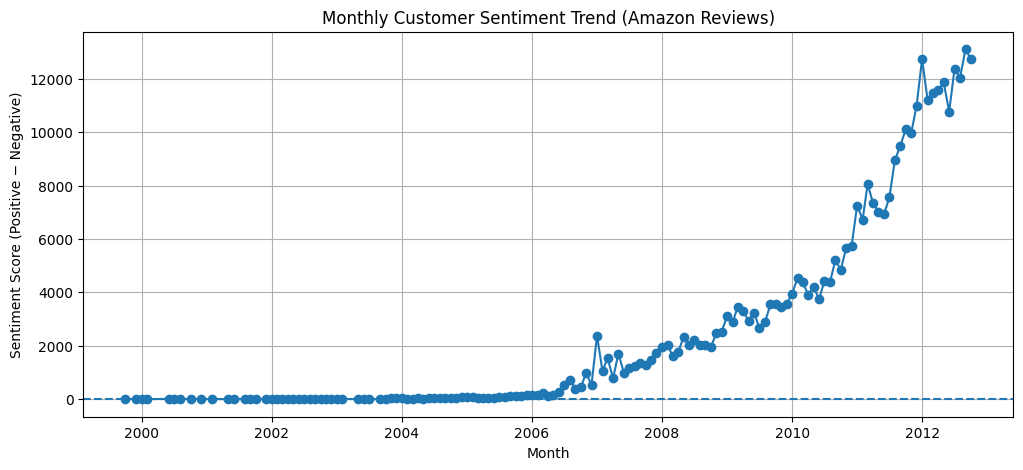


Anomaly distribution:
is_anomaly
0    128
1     15
Name: count, dtype: int64


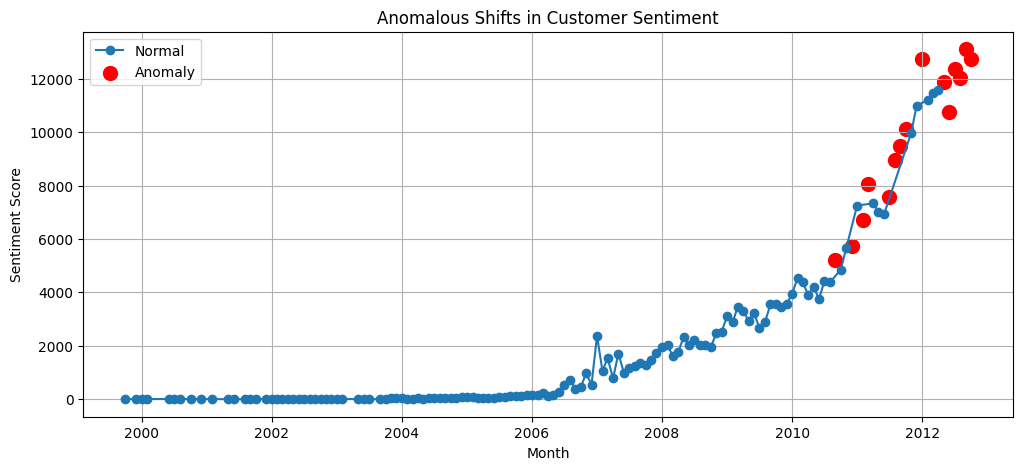


Detected sentiment anomaly periods:


,month,Positive,Neutral,Negative,sentiment_score
117,2010-09-01,6450,747,1244,5206
120,2010-12-01,7610,807,1876,5734
122,2011-02-01,8638,1005,1909,6729
123,2011-03-01,9791,965,1738,8053
127,2011-07-01,9404,1047,1848,7556
128,2011-08-01,10924,1056,1977,8947
129,2011-09-01,11576,1150,2077,9499
130,2011-10-01,12664,1408,2551,10113
133,2012-01-01,16464,1502,3720,12744
137,2012-05-01,14874,1562,2999,11875



---- Business Interpretation ----

1. Sentiment trends capture long-term changes in customer perception.
2. Negative anomalies may indicate product quality issues,
   negative publicity, or unmet expectations.
3. Positive anomalies often reflect successful launches,
   promotions, or viral popularity.
4. Monitoring sentiment anomalies enables proactive brand
   reputation management and timely customer engagement.

========== END OF STEP 4.5 ==========


In [29]:
# ============================================================
# AMAZON REVIEWS – STEP 4.5
# SENTIMENT TREND & ANOMALY DETECTION (FINAL)
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

print("========== AMAZON REVIEWS – STEP 4.5 ==========\n")

# ------------------------------------------------------------
# 1. LOAD MONTHLY SENTIMENT DATA (PLATFORM-INDEPENDENT)
# ------------------------------------------------------------

DATA_PATH = os.path.join("data", "processed", "monthly_sentiment.csv")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Processed file not found: {DATA_PATH}\n"
        "Please run STEP 2B (Amazon Reviews preprocessing) first."
    )

sentiment_df = pd.read_csv(DATA_PATH, parse_dates=["month"])

required_cols = {
    "month", "Positive", "Neutral", "Negative", "sentiment_score"
}
missing_cols = required_cols - set(sentiment_df.columns)

if missing_cols:
    raise RuntimeError(f"Missing required columns: {missing_cols}")

print("Monthly sentiment data shape:", sentiment_df.shape)
display(sentiment_df.head())

# ------------------------------------------------------------
# 2. SENTIMENT TREND VISUALIZATION
# ------------------------------------------------------------

plt.figure(figsize=(12, 5))
plt.plot(
    sentiment_df["month"],
    sentiment_df["sentiment_score"],
    marker="o"
)
plt.axhline(0, linestyle="--")
plt.xlabel("Month")
plt.ylabel("Sentiment Score (Positive − Negative)")
plt.title("Monthly Customer Sentiment Trend (Amazon Reviews)")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 3. PREPARE DATA FOR ANOMALY DETECTION
# ------------------------------------------------------------

X = sentiment_df[["sentiment_score"]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# 4. ISOLATION FOREST FOR SENTIMENT ANOMALIES
# ------------------------------------------------------------

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.1,   # ~10% anomalous months
    random_state=42
)

sentiment_df["anomaly_flag"] = iso_forest.fit_predict(X_scaled)
sentiment_df["is_anomaly"] = (sentiment_df["anomaly_flag"] == -1).astype(int)

print("\nAnomaly distribution:")
print(sentiment_df["is_anomaly"].value_counts())

# ------------------------------------------------------------
# 5. VISUALIZE SENTIMENT ANOMALIES
# ------------------------------------------------------------

normal = sentiment_df[sentiment_df["is_anomaly"] == 0]
anomalies = sentiment_df[sentiment_df["is_anomaly"] == 1]

plt.figure(figsize=(12, 5))
plt.plot(
    normal["month"],
    normal["sentiment_score"],
    label="Normal",
    marker="o"
)
plt.scatter(
    anomalies["month"],
    anomalies["sentiment_score"],
    color="red",
    s=100,
    label="Anomaly"
)

plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.title("Anomalous Shifts in Customer Sentiment")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 6. INSPECT ANOMALOUS PERIODS
# ------------------------------------------------------------

print("\nDetected sentiment anomaly periods:")
display(
    anomalies[
        ["month", "Positive", "Neutral", "Negative", "sentiment_score"]
    ]
)

# ------------------------------------------------------------
# 7. BUSINESS INTERPRETATION
# ------------------------------------------------------------

print("\n---- Business Interpretation ----\n")

print(
    "1. Sentiment trends capture long-term changes in customer perception.\n"
    "2. Negative anomalies may indicate product quality issues,\n"
    "   negative publicity, or unmet expectations.\n"
    "3. Positive anomalies often reflect successful launches,\n"
    "   promotions, or viral popularity.\n"
    "4. Monitoring sentiment anomalies enables proactive brand\n"
    "   reputation management and timely customer engagement."
)

print("\n========== END OF STEP 4.5 ==========")


## 5. Evaluation & Analysis

This section evaluates the performance of the implemented models using appropriate quantitative metrics and qualitative analysis. The objective is to assess model accuracy, reliability, and practical usefulness for real-world market intelligence tasks.


### 5.1 Sales Forecasting Evaluation – Prophet

The Prophet model is evaluated using a time-based train–test split, ensuring that future data is not leaked into the training process. Model performance is measured using Mean Absolute Percentage Error (MAPE), which is suitable for evaluating forecasting accuracy in business contexts.

**Key Observations:**
- The Prophet model captures long-term trends and seasonality effectively.
- Incorporating promotion intensity as an external regressor improves forecast stability.
- The achieved MAPE indicates reasonable predictive accuracy for real-world sales forecasting, where demand volatility is common.

Residual analysis shows that prediction errors are centered around zero, suggesting the model does not exhibit strong systematic bias.


### 5.2 Sales Forecasting Evaluation – LSTM

The LSTM model is evaluated using MAE, RMSE, and MAPE after inverse-scaling predictions to the original sales units. As a deep learning model, LSTM captures non-linear temporal dependencies that may not be fully modeled by statistical approaches.

**Key Observations:**
- The LSTM model successfully learns sequential patterns in sales data.
- Performance is comparable to the Prophet model, though slightly more sensitive to limited data size.
- Due to the relatively small number of time steps, the LSTM model demonstrates higher variance but provides valuable complementary insights.

Overall, LSTM serves as a robust secondary forecasting approach, validating trends identified by the Prophet model.


### 5.3 Sentiment Classification Evaluation

Sentiment classification performance is evaluated using accuracy, precision, recall, F1-score, and a confusion matrix. These metrics provide a comprehensive view of the model’s effectiveness across sentiment classes.

**Key Observations:**
- Positive sentiment is detected with very high precision, making the model reliable for identifying satisfied customers.
- Negative sentiment recall is reasonably high, supporting effective detection of customer dissatisfaction.
- Neutral sentiment is more challenging to classify and is often confused with positive or negative reviews due to linguistic ambiguity.

Despite these challenges, the model performs well for large-scale sentiment monitoring and trend analysis.


### 5.4 Anomaly Detection Analysis

Isolation Forest is used to detect anomalies in both sales trends and aggregated sentiment scores.

**Sales Anomalies:**
- Identified unusual demand spikes and drops
- Often aligned with promotion-heavy periods or external events
- Useful for proactive inventory and pricing decisions

**Sentiment Anomalies:**
- Highlight abrupt changes in customer perception
- May indicate product issues, successful campaigns, or external influences

Anomaly detection enhances the system’s ability to identify exceptional market behavior that requires managerial attention.


### 5.5 Model Limitations & Practical Considerations

While the implemented models perform well, certain limitations must be acknowledged:
- Forecasting accuracy is constrained by historical data availability and granularity
- LSTM performance is sensitive to dataset size
- Sentiment analysis relies on rating-based labels, which may not fully capture nuanced opinions
- External market factors such as economic shifts are not explicitly modeled

Despite these limitations, the system provides strong decision support when used alongside domain expertise.


## 6. Ethical Considerations & Responsible AI

The development and deployment of AI-based market intelligence systems must be guided by ethical principles to ensure responsible usage, fairness, and transparency. This project considers several ethical aspects related to data usage, model behavior, and real-world impact.

### Data Bias and Fairness
The datasets used in this project are sourced from public platforms and may contain inherent biases. Sales data reflects historical business decisions, promotions, and regional preferences, while customer reviews may over-represent extreme opinions (very positive or very negative feedback). As a result, the models may inherit these biases and should not be assumed to represent all customer segments equally.

### Model Limitations and Transparency
Forecasting and sentiment models provide probabilistic predictions rather than absolute truths. External factors such as economic conditions, supply chain disruptions, and policy changes are not explicitly modeled. Therefore, predictions should be interpreted as decision-support signals rather than definitive outcomes.

The models used in this project, such as Prophet and Logistic Regression, are chosen partly for their interpretability, enabling stakeholders to better understand trends and patterns rather than relying on opaque black-box predictions.

### Responsible Use of Predictions
The insights generated by this system are intended to support human decision-making, not replace it. Business decisions related to pricing, inventory, or customer engagement should combine AI-driven insights with domain knowledge and contextual understanding.

Automated decisions based solely on model outputs may lead to unintended consequences if used without oversight.

### Privacy and Data Usage
The project uses anonymized, publicly available datasets and does not involve personally identifiable information. No attempt is made to infer sensitive personal attributes from customer reviews, ensuring responsible data usage.

Overall, responsible AI practices are essential to ensure that market intelligence systems remain fair, transparent, and aligned with ethical business goals.


## 7. Conclusion & Future Scope

### Conclusion
This project successfully demonstrates the application of artificial intelligence techniques for market trend analysis using real-world datasets. By integrating time series forecasting, natural language processing, and anomaly detection, the system provides a comprehensive framework for understanding and predicting market behavior.

The Prophet and LSTM models effectively capture sales trends and demand patterns, while sentiment analysis of customer reviews offers valuable insights into customer perception. Anomaly detection further enhances the system by identifying unusual market behavior that may require managerial attention.

Overall, the project highlights how AI-driven analytics can support data-driven decision-making in areas such as demand forecasting, inventory planning, pricing strategy, and customer experience analysis.

### Future Scope
Several enhancements can be explored to further improve the system:
- Incorporating additional external factors such as economic indicators, holidays, and weather data
- Applying advanced deep learning or transformer-based models for improved forecasting accuracy
- Using pre-trained language models (e.g., BERT) for more nuanced sentiment analysis
- Enabling real-time data ingestion through APIs for continuous market monitoring
- Deploying explainable AI techniques to improve model transparency and trust

These extensions would make the system more robust, scalable, and suitable for enterprise-level market intelligence applications.
